## 環境構築とライブラリの準備

本プロジェクトでは、LSTMベースのディープラーニングモデルを用いて時系列データの予測を行うため、以下の主要なライブラリやツールをインポートしている

### データ処理関連
- `pandas`, `numpy`: データの前処理や数値計算に使用
- `random`: 乱数の制御（再現性確保のため）
- `train_test_split`, `MinMaxScaler`: scikit-learnを用いたデータの分割とスケーリング

### 可視化関連
- `matplotlib`, `seaborn`: データや予測結果の可視化

### 評価指標
- `mean_squared_error`, `mean_absolute_error`, `r2_score`: 回帰タスクの評価指標として使用

### TensorFlow/Keras関連
- `tensorflow`: LSTMモデルの構築・学習に使用
- `LSTM`, `Bidirectional`, `Dropout`, `Dense` など: モデルを構成する主要なレイヤー
- `LayerNormalization`, `BatchNormalization`, `Add`: モデルの正規化と構造の改善
- `l2`: 重み正則。
- `EarlyStopping`, `ReduceLROnPlateau`: 過学習防止や学習率の調整のためのコールバック
- `Adam`, `AdamW`: 最適化アルゴリズム

### 再現性の確保
実験の再現性を確保するため、`random`, `numpy`, `tensorflow` の乱数シードを固定しています





In [28]:
import pandas as pd
import numpy as np
import random
from random import choice

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional, Dropout, Dense, LayerNormalization, Add, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW

# 再現性確保
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)



## データ前処理と特徴量エンジニアリング

特徴量の拡充およびデータ拡張・正規化・時系列データの整形を行う一連の処理を実装している

- データセット（`ring_data.csv`または`ias_data.csv`）を読み込み
- 体温・室温のラグ特徴量（1時刻前）
- 差分特徴量（体温と室温の差分とそのラグ）
- 移動平均・移動分散（ウィンドウサイズ3）
- 欠損値の削除（shiftやrollingでできたNaN）



## 実行結果例

- 元データ数: `X_raw.shape[0]`
- 拡張後データ数: `X_combined.shape[0]`
- 時系列入力形状: `(サンプル数, 時系列長さ=3, 特徴量数)`
- ターゲット形状: `(サンプル数, 1)`




In [29]:
# ファイル読み込み
df = pd.read_csv("../datasets/ring_data.csv")

# --- ラグ特徴 ---
df['体温_lag1'] = df['体温'].shift(1)
df['室温_lag1'] = df['室温'].shift(1)

# --- 差分特徴量（デルタ温度）---
df['delta_temp'] = df['室温'] - df['体温']
df['delta_temp_lag1'] = df['室温_lag1'] - df['体温_lag1']

# --- 移動平均・移動分散（ウィンドウサイズ3）---
window_size = 3
df['体温_ma3'] = df['体温'].rolling(window=window_size).mean()
df['体温_var3'] = df['体温'].rolling(window=window_size).var()
df['室温_ma3'] = df['室温'].rolling(window=window_size).mean()
df['室温_var3'] = df['室温'].rolling(window=window_size).var()

# 欠損値削除
df.dropna(inplace=True)

# 特徴量とターゲット
features = [
    '体温', '体温_lag1',  '体温_ma3', '体温_var3',
    '室温', '室温_lag1',  '室温_ma3', '室温_var3',
    'delta_temp', 'delta_temp_lag1'
]
target = '適温'

# 2次元配列
X_raw = df[features].values
y_raw = df[[target]].values 

# --- 生データを準備 ---
X_raw = df[features].values
y_raw = df[[target]].values

# --- Step 1: テストデータ分離--
test_size = 0.2
split_index = int(len(X_raw) * (1 - test_size))

X_trainval_raw = X_raw[:split_index]     # 訓練 + 検証
y_trainval_raw = y_raw[:split_index]
X_test_raw = X_raw[split_index:]         
y_test_raw = y_raw[split_index:]

# --- 検証データ分離---
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_trainval_raw, y_trainval_raw, test_size=0.2, random_state=42, shuffle=False
)

# --- 訓練データだけノイズで拡張 ---
noise_std = 0.01 * np.std(X_train_raw, axis=0)
noise = np.random.normal(loc=0.0, scale=noise_std, size=X_train_raw.shape)
X_train_aug = X_train_raw + noise
y_train_aug = y_train_raw.copy()

# --- 拡張データと結合---
X_train_combined = np.vstack([X_train_raw, X_train_aug])
y_train_combined = np.vstack([y_train_raw, y_train_aug])
# --- 検証データ分割---
X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(
    X_train_combined, y_train_combined, test_size=0.2, random_state=42, shuffle=False
)

# --- 正規化 ---
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_sub)
X_val_scaled = feature_scaler.transform(X_val_sub)
X_test_scaled = feature_scaler.transform(X_test_raw)

target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train_sub)
y_val_scaled = target_scaler.transform(y_val_sub)
y_test_scaled = target_scaler.transform(y_test_raw)

# --- 時系列データ生成関数 ---
def create_sequences(X, y, time_steps=3):
    n_samples = len(X) - time_steps
    X_seq = np.array([X[i:i+time_steps] for i in range(n_samples)])
    y_seq = y[time_steps:]
    return X_seq, y_seq

# --- 時系列シーケンス作成 ---
time_steps = 4
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# --- データ数出力 ---
print("元訓練データ数:", X_train_raw.shape[0])
print("拡張後訓練データ数:", X_train_combined.shape[0])
print("検証データ数:", X_val_sub.shape[0])
print("テストデータ数:", X_test_raw.shape[0])

# --- 入力形状・ターゲット形状出力 ---
print(f"訓練データ入力形状: {X_train_seq.shape}, ターゲット形状: {y_train_seq.shape}")
print(f"検証データ入力形状: {X_val_seq.shape}, ターゲット形状: {y_val_seq.shape}")
print(f"テストデータ入力形状: {X_test_seq.shape}, ターゲット形状: {y_test_seq.shape}")

# --- データ分布 ---
print(f"訓練データターゲットの平均: {np.mean(y_train_seq):.4f}")
print(f"訓練データターゲットの標準偏差: {np.std(y_train_seq):.4f}")
print(f"検証データターゲットの平均: {np.mean(y_val_seq):.4f}")
print(f"検証データターゲットの標準偏差: {np.std(y_val_seq):.4f}")
print(f"テストデータターゲットの平均: {np.mean(y_test_seq):.4f}")
print(f"テストデータターゲットの標準偏差: {np.std(y_test_seq):.4f}")


元訓練データ数: 244
拡張後訓練データ数: 488
検証データ数: 98
テストデータ数: 77
訓練データ入力形状: (386, 4, 10), ターゲット形状: (386, 1)
検証データ入力形状: (94, 4, 10), ターゲット形状: (94, 1)
テストデータ入力形状: (73, 4, 10), ターゲット形状: (73, 1)
訓練データターゲットの平均: 0.6708
訓練データターゲットの標準偏差: 0.2709
検証データターゲットの平均: 0.5160
検証データターゲットの標準偏差: 0.2113
テストデータターゲットの平均: 0.7183
テストデータターゲットの標準偏差: 0.1369


# LSTMモデルのハイパーパラメータチューニング


## 概要

- 3つの主要ハイパーパラメータ候補のリスト（`epochs`, `batch_size`, `units`）に加え、`dropout率`や`L2正則化強度`も複数候補からランダムに選択してモデルを15回学習させる
- 各試行で以下を実施：
  - 双方向LSTMを2層重ね、層ごとに`LayerNormalization`を適用
  - 残差接続と`gelu`活性化を含むDense層でさらに処理
  - 最後に1ユニットのDense層で回帰値を出力
  - オプティマイザはAdamWを使用し、損失関数はMSE
  - 学習時はEarlyStoppingとReduceLROnPlateauのコールバックを利用し、過学習防止と学習率調整を行う

## チューニング手法

- 各試行で上記パラメータをランダムに選択し、モデルの学習を実施。
- 検証データでの損失（`val_loss`）をもとに最良モデルとパラメータを保存
- 15回の試行の中で最も低い検証損失を出したパラメータセットとモデルを最終的に採用

## 実装のポイント

- 双方向LSTMにより時系列の前後情報を活用
- LayerNormalizationにより学習の安定化を図る
- 残差接続を入れることで深いネットワークでも勾配消失を防止
- AdamWオプティマイザを用いて、重み減衰（による正則化も実現
- EarlyStoppingとReduceLROnPlateauにより効率的な学習を実現

---

適切なハイパーパラメータ探索の自動化が可能であり実際の時系列データ予測タスクへの応用例として有効である


In [30]:
# ハイパーパラメータの範囲
epochs_list = [60,90,120]
batch_sizes = [4, 8, 16]
lstm_units = [60,90,120]
dropout_rates = [0.001,0.01,0.05]
l2_reg_strengths = [0.01,0.05,0.1]
best_loss = float('inf')
best_params = None
best_model = None
for _ in range(15):
    epochs = choice(epochs_list)
    batch_size = choice(batch_sizes)
    units = choice(lstm_units)
    dropout = choice(dropout_rates)
    l2_reg_strength = choice(l2_reg_strengths)

    print(f"Training with Epochs: {epochs}, Batch Size: {batch_size}, Units: {units}, Dropout: {dropout}, L2: {l2_reg_strength}")

    # --- モデル構築 ---
    input_layer = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])) #(タイムステップ数, 特徴量数)

    # 双方向LSTM（1層目）#(batch_size, timesteps, units*2)
    out1 = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg_strength)))(input_layer)
    input2 = LayerNormalization()(out1)

    # 双方向LSTM（2層目） #
    out2 = Bidirectional(LSTM(units // 2, return_sequences=False, kernel_regularizer=l2(l2_reg_strength)))(input2)
    x = LayerNormalization()(out2)

    residual = x
    residual_units = K.int_shape(residual)[-1]  # 静的にユニット数を取得
    x = Dense(
        residual_units, 
        activation='gelu', 
        kernel_regularizer=l2(l2_reg_strength)
        )(x)
    residual_added = Add()([x, residual])
    resi_seq = LayerNormalization()(residual_added)
    out_resi = Dropout(dropout)(resi_seq)

    # 最終出力
    output = Dense(1)(out_resi)    
    # モデル定義
    model = Model(inputs=input_layer, outputs=output)

    # コンパイル（AdamW）
    model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), loss='mse')

    # コールバック
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)#過学習を防ぎ、無駄な学習時間を減らす
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)#学習が停滞したら学習率を下げて、最適化を

    # 学習
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_seq, y_val_seq),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]
    print(f"Validation Loss: {val_loss}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = (epochs, batch_size, units, dropout, l2_reg_strength)
        best_model = model
        best_history = history

print(f"Best Params: {best_params}")
print(f"Best Val Loss: {best_loss}")

Training with Epochs: 120, Batch Size: 4, Units: 60, Dropout: 0.05, L2: 0.05

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Validation Loss: 0.010342073626816273
Training with Epochs: 60, Batch Size: 16, Units: 120, Dropout: 0.05, L2: 0.1
Validation Loss: 0.06600889563560486
Training with Epochs: 90, Batch Size: 4, Units: 90, Dropout: 0.01, L2: 0.1

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Validation Loss: 0.012554332613945007
Training with Epochs: 60, Batch Size: 4, Units: 120, Dropout: 0.001, L2: 0.05

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 49: ReduceLROnPlateau reduc

## 適温予測モデルの評価と結果の可視化


### モデル評価
- テストデータに対して予測を行い、複数の指標で評価しました。
  - MSE：誤差の二乗平均で全体の精度を定量化
  - RMSE：誤差の大きさを直感的に把握できる単位で評価
  - MAE：誤差の絶対値平均で外れ値の影響を軽減
  - R²スコア：モデルの説明力を示す指標
  - in_comfort_range：予測値がユーザの快適温度範囲内に収まっていた割合。、1でない場合は快適さを損なう予測が含まれている
  - median_distance：快適範囲の中央値と予測値の絶対誤差の平均


### 損失推移の可視化

- 損失の減少傾向を確認することで、モデルの収束状態や過学習の有無、正しく学習できているかを視覚的に判断

### 予測値と実測値の比較

- 逆正規化した予測適温と実際の適温の時間的推移をグラフにて比較
- 予測値（青線）と実測値（赤点線）を並べて描画することで、モデルの予測がどの程度実際の温度に近いかを直感的に把握可能
---

これにより、モデルの性能評価と結果の信頼性を示している


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 727ms/step
Test MSE: 0.1574
Test RMSE: 0.3967
Test MAE: 0.3433
Test R^2 Score: 0.7950
Comfort Range Accuracy : 100.00%
Mean Distance to Comfort Center (22.35°C): 0.6436
Epoch | Train Loss | Val Loss
    1 | 17.326580 | 10.705573
    2 | 7.621682 | 5.335870
    3 | 4.146220 | 3.177151
    4 | 2.608020 | 2.076289
    5 | 1.761337 | 1.440296
    6 | 1.257321 | 1.057970
    7 | 0.916293 | 0.765822
    8 | 0.692259 | 0.598985
    9 | 0.548858 | 0.473133
   10 | 0.418325 | 0.369531
   11 | 0.334912 | 0.296241
   12 | 0.262066 | 0.221902
   13 | 0.211989 | 0.177816
   14 | 0.170130 | 0.146388
   15 | 0.138370 | 0.120842
   16 | 0.111287 | 0.102650
   17 | 0.090977 | 0.089719
   18 | 0.076768 | 0.064674
   19 | 0.063970 | 0.052436
   20 | 0.053752 | 0.044436
   21 | 0.045721 | 0.036516
   22 | 0.038709 | 0.032228
   23 | 0.030447 | 0.027200
   24 | 0.027711 | 0.024613
   25 | 0.024538 | 0.023854
   26 | 0.019049 | 0.016788
   27 | 0.017932 | 0.021426
   28 | 0.01718

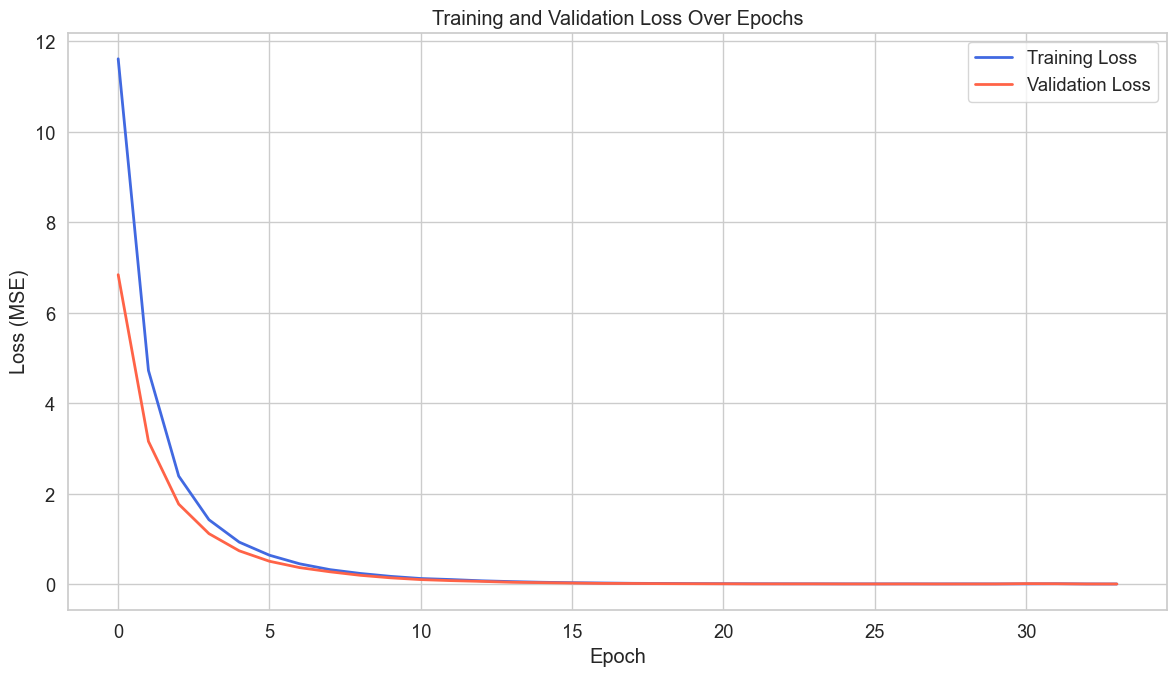

C:\Users\bsksh\AppData\Local\Temp\ipykernel_17864\2882762461.py:57: UserWarning: Glyph 8451 (\N{DEGREE CELSIUS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\bsksh\Documents\programm\github\personal-developments\lstm-temp-forecasting\venv-py310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8451 (\N{DEGREE CELSIUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


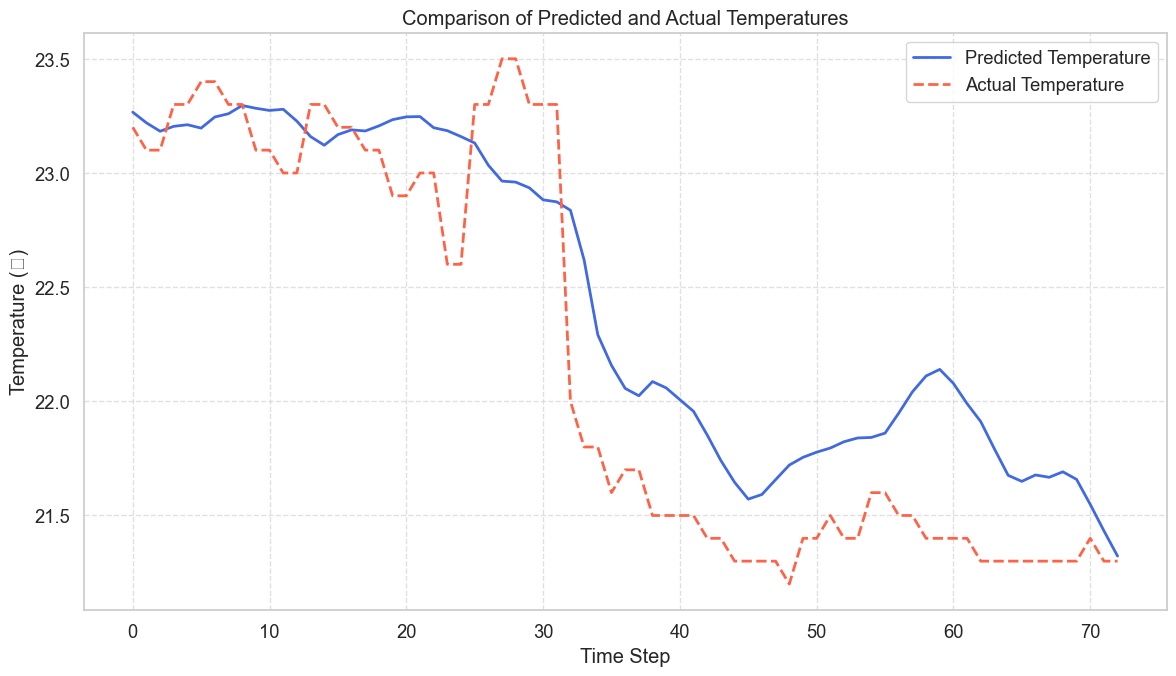

In [31]:
# ベストモデルで予測
predictions = best_model.predict(X_test_seq)

# 逆正規化
predicted_temps = target_scaler.inverse_transform(predictions).flatten()
actual_temps = target_scaler.inverse_transform(y_test_seq).flatten()

# 精度指標計算
mse = mean_squared_error(actual_temps, predicted_temps)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_temps, predicted_temps)
r2 = r2_score(actual_temps, predicted_temps)
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

# 予測値が適温帯に含まれている割合
comfort_range_min = actual_temps.min()
comfort_range_max = actual_temps.max()
in_comfort_range = ((predicted_temps >= comfort_range_min) & (predicted_temps <= comfort_range_max)).mean()
print(f"Comfort Range Accuracy : {in_comfort_range * 100:.2f}%")

# 中央値との差分
comfort_center = (comfort_range_min + comfort_range_max) / 2  
median_distance = np.mean(np.abs(predicted_temps - comfort_center))
print(f"Mean Distance to Comfort Center ({comfort_center}°C): {median_distance:.4f}")
# seabornスタイル設定
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
# 学習後の履歴表示
print("Epoch | Train Loss | Val Loss")
for epoch in range(len(history.history['loss'])):
    train_loss = history.history['loss'][epoch]
    val_loss = history.history['val_loss'][epoch]
    print(f"{epoch+1:5d} | {train_loss:.6f} | {val_loss:.6f}")

# 損失推移グラフ
plt.figure(figsize=(12, 7))
sns.lineplot(data=best_history.history['loss'], label='Training Loss', color='royalblue', linewidth=2)
sns.lineplot(data=best_history.history['val_loss'], label='Validation Loss', color='tomato', linewidth=2)
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

# 予測と実際の適温推移グラフ
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(len(predicted_temps)), y=predicted_temps, label='Predicted Temperature', color='royalblue', linewidth=2)
sns.lineplot(x=range(len(actual_temps)), y=actual_temps, label='Actual Temperature', color='tomato', linestyle='--', linewidth=2)
plt.title('Comparison of Predicted and Actual Temperatures')
plt.xlabel('Time Step')
plt.ylabel('Temperature (℃)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



**CSVファイルへの保存**  
   指定したファイル名（`ring_lstm.csv`）でCSV形式で`.\results`へ保存し、保存パスを出力している


In [ ]:
import os


# 評価指標を辞書でまとめる
results_dict = {
    "MSE": [mse],
    "RMSE": [rmse],
    "MAE": [mae],
    "R2": [r2],
    "in_comfort_range" : [in_comfort_range],
    "median_distance" : [median_distance]
}

# DataFrameに変換
results_df = pd.DataFrame(results_dict)

# 保存先ディレクトリ
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)  # フォルダがなければ作成

# 保存ファイル名
filename = "ring_lstm.csv"  

# フルパスを作成

filepath = os.path.join(results_dir, filename)

# CSV保存（indexは不要）
results_df.to_csv(filepath, index=False)

print(f"評価結果を保存しました: {filepath}")


評価結果を保存しました: ../results\ias_lstm.csv
